# Experiment: MLP / Sphere

Compares XGB baseline against MLP on sphere dataset.

# Setup

In [1]:
from time import time

import jax
import seaborn as sns
import wandb
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import xjax
from xjax.signals import train_epoch_completed

In [2]:
rng = jax.random.key(42)

# Dataset

In [3]:
# Generate circle dataset
rng, dataset_rng = jax.random.split(rng)
X, y = xjax.datasets.sphere(rng=dataset_rng)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

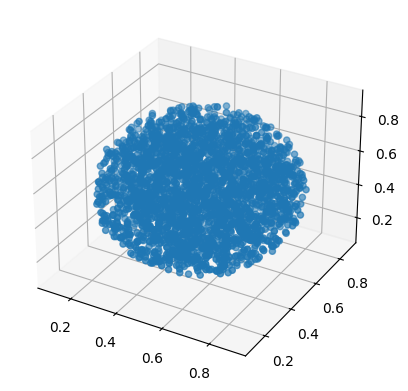

In [4]:
fig = plt.figure()

mask = y == 1.0
X_positive = X[mask]
y_positive = y[mask]
ax = fig.add_subplot(projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])

# Modeling

## Baseline

In [5]:
# Construct model
model_xgb = xjax.models.sklearn.xgb_classifier()

In [6]:
# Train model
model_xgb = xjax.models.sklearn.train(model_xgb, X=X_train, y=y_train)

In [7]:
# Test model
y_score_xgb = xjax.models.sklearn.predict(model_xgb, X=X_test)
auroc_xgb = roc_auc_score(y_test, y_score_xgb)

print(f"XGB AUROC: {auroc_xgb:0.4f}")

XGB AUROC: 0.9986


## Candidate

In [8]:
# Hyperparameters
hiddens = [5, 5, 5]
batch_size = 10
epochs = 10
learning_rate = 0.01

In [9]:
wandb.init(
    project="mlp-sphere",
    config={
        "baseline": "xgb",
        "hiddens": hiddens,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
    },
)

wandb: Currently logged in as: andrewsomesyoung (andrewsomesyoung-projects). Use `wandb login --relogin` to force relogin


In [10]:
# Construct model
rng, model_rng = jax.random.split(rng)
model_nn, params = xjax.models.flax.mlp(rng=model_rng, inputs=3, hiddens=hiddens)

In [11]:
start_time = time()

# Monitor model


@train_epoch_completed.connect_via(model_nn)
def monitor_model(model, epoch, loss, **_):
    elapsed = time() - start_time

    # Emit event
    wandb.log({"epoch": epoch, "loss": loss, "elapsed": elapsed})

    print(f"epoch={epoch}, loss={loss:0.4f}, elapsed={elapsed:0.2f}")

In [12]:
# Train model
params = xjax.models.flax.train(
    model_nn,
    params=params,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
)

epoch=0, loss=0.2057, elapsed=2.59
epoch=1, loss=0.1183, elapsed=4.42
epoch=2, loss=0.1056, elapsed=6.23
epoch=3, loss=0.1020, elapsed=8.00
epoch=4, loss=0.0574, elapsed=9.81
epoch=5, loss=0.0469, elapsed=11.61
epoch=6, loss=0.0360, elapsed=13.37
epoch=7, loss=0.0426, elapsed=15.13
epoch=8, loss=0.0410, elapsed=16.90
epoch=9, loss=0.0354, elapsed=18.66


In [13]:
# Test model
y_score_nn = xjax.models.flax.predict(model_nn, params=params, X=X_test)
auroc_nn = roc_auc_score(y_test, y_score_nn)

print(f"NN AUROC: {auroc_nn:0.4f}")

NN AUROC: 0.9961


# Analysis

In [14]:
# Track auroc
wandb.log({"auroc_xgb": auroc_xgb, "auroc_nn": auroc_nn})

## Predictions

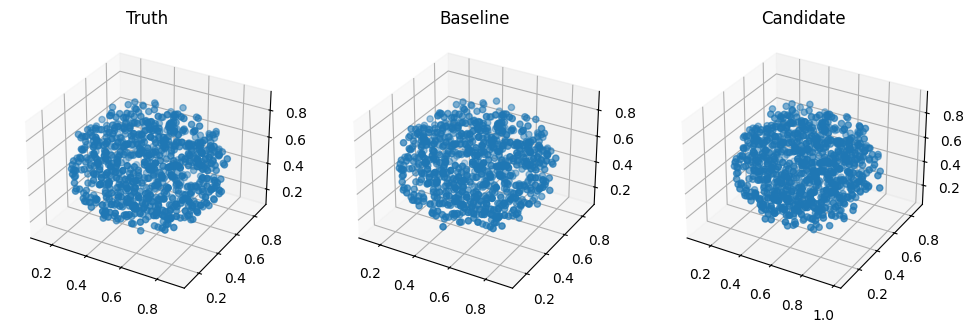

In [15]:
y_pred_xgb = (y_score_xgb > 0.5).astype(int)
y_pred_nn = (y_score_nn > 0.5).astype(int)

fig = plt.figure()
fig.set_size_inches(12, 4)

mask = y_test == 1.0
X_positive = X_test[mask]
y_positive = y_test[mask]
ax = fig.add_subplot(131, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Truth")

mask = y_pred_xgb == 1.0
X_positive = X_test[mask]
y_positive = y_pred_xgb[mask]
ax = fig.add_subplot(132, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Baseline")

mask = y_pred_nn == 1.0
X_positive = X_test[mask]
y_positive = y_pred_nn[mask]
ax = fig.add_subplot(133, projection="3d")
ax.scatter(X_positive[:, 0], X_positive[:, 1], X_positive[:, 2])
ax.set_title("Candidate")

wandb.log({"predictions": wandb.Image(plt)})

## ROC Curves

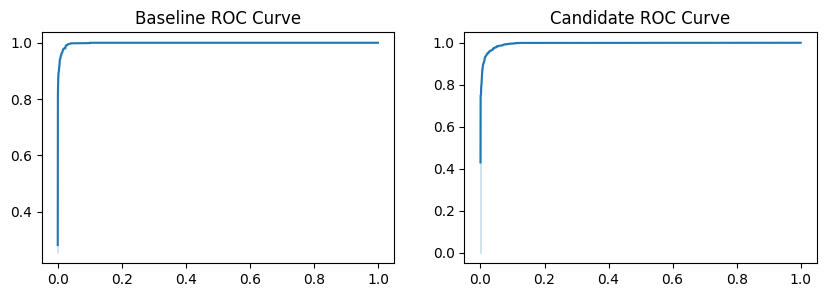

In [16]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)

fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

sns.lineplot(x=fpr_xgb, y=tpr_xgb, ax=axs[0])
axs[0].set_title("Baseline ROC Curve")

sns.lineplot(x=fpr_nn, y=tpr_nn, ax=axs[1])
axs[1].set_title("Candidate ROC Curve")

wandb.log({"roc_curve": wandb.Image(plt)})

# Cleanup

In [17]:
wandb.finish()

auroc_nn,▁
auroc_xgb,▁
elapsed,▁▂▃▃▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▄▂▁▁▁▁▁
auroc_nn,0.99614
auroc_xgb,0.99855
elapsed,18.65615
epoch,9
loss,0.03542
